In [12]:
from pandas import read_csv
from matplotlib import pyplot
from random import shuffle
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import platform
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sys import platform
import pydot
import graphviz
from keras.utils import plot_model
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [13]:
def read_and_process_data(directory_path):
    data_frames = []
    columns_to_extract = ['hand_r_X', 'hand_r_Y', 'hand_r_Z', 'hand_r_Ox', 'hand_r_Oy', 'hand_r_Oz', 'Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

    # Assuming each cycle has exactly 356 data points
    total_data_points = 356

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory_path, file_name)
            participant = int(os.path.basename(file_path).split('_')[0])
            cycle_id = os.path.basename(file_path).split('_')[1].split('.')[0]  # Extract cycle_id
            intensity = cycle_id[:4]  # Extract the first four characters of cycle_id as intensity

            # Read data from CSV and select only the desired columns
            df = pd.read_csv(file_path, usecols=columns_to_extract)

            # Add participant ID, cycle_id, and participant_cycle_id as features
            df['Participant'] = participant
            df['Cycle_ID'] = cycle_id
            df['Participant_Cycle_ID'] = f"{participant}_{cycle_id}"

            # Add normalized_cycle_position
            df['Normalized_Cycle_Position'] = df.index / (total_data_points - 1)
            df['Intensity'] = intensity  # this is either "HIIT" or "MICT"

            data_frames.append(df)

    # Concatenate all data frames
    processed_data = pd.concat(data_frames, ignore_index=True)

    # Merge with participant weights
    weights_df = pd.read_csv("Participant_Weights_Median_Imputed.csv")
    weights_df['Weight'] = weights_df['Weight'].astype(float)
    weights_df['Wingspan'] = weights_df['Wingspan'].astype(float)
    processed_data = pd.merge(processed_data, weights_df, left_on='Participant', right_on='Participant')

    return processed_data

 # Set up paths
data_directory = "Processed Data for ML"

# Read and process data
data = read_and_process_data(data_directory)
data['Intensity'] = data['Intensity'].map({'HIIT': 0.9, 'MICT': 0.5})
data = data.drop(columns=['Participant', 'Cycle_ID', 'Participant_Cycle_ID'])
data = data[data.columns[-4:].tolist() + data.columns[:-4].tolist()]
data.head()

,Normalized_Cycle_Position,Intensity,Weight,Wingspan,hand_r_X,hand_r_Y,hand_r_Z,hand_r_Ox,hand_r_Oy,hand_r_Oz,Fx,Fy,Fz,Tx,Ty,Tz
0,0.000000,0.9,160.0,172.72,0.020537,3.736630,0.064170,-33.584860,22.706178,23.796136,-51.709616,-46.127911,-17.304707,2.308679,-2.609106,0.160727
1,0.002817,0.9,160.0,172.72,-1.002058,6.681181,0.104367,-35.125067,23.634133,25.040792,-52.574803,-46.360920,-17.348756,2.313128,-2.647273,0.163128
2,0.005634,0.9,160.0,172.72,-1.318368,8.560281,0.139141,-32.797160,21.771117,23.734505,-53.439989,-46.593930,-17.392805,2.317576,-2.685440,0.165529
3,0.008451,0.9,160.0,172.72,-1.547885,10.162002,0.177352,-32.127317,20.874672,23.749559,-54.305175,-46.826939,-17.436854,2.322025,-2.723607,0.167930
4,0.011268,0.9,160.0,172.72,-2.278769,10.436472,0.197331,-33.084583,20.902988,25.077196,-55.262267,-47.146885,-17.449009,2.328763,-2.764219,0.170598


In [14]:
data2 = np.empty([int(len(data)/356),356,len(data.columns)])
for i in range(int(len(data)/356)):
    data2[i,:,:] = data[356*i:i*356+356]
np.random.shuffle(data2)
print(data2.shape)

(239, 356, 16)


In [15]:
# Split into train, validation, and test datasets: X - inputs, y - outputs
train_X = data2[0:int(len(data2)*0.7),:,:10]
train_y = data2[0:int(len(data2)*0.7),:,10:]
test_X = data2[int(len(data2)*0.7)+1:int(len(data2)*0.85),:,:10]
test_y = data2[int(len(data2)*0.7)+1:int(len(data2)*0.85),:,10:]
val_X = data2[int(len(data2)*0.85)+1:,:,:10]
val_y = data2[int(len(data2)*0.85)+1:,:,10:]


In [16]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(val_X.shape)
print(val_y.shape)

(167, 356, 10)
(167, 356, 6)
(35, 356, 10)
(35, 356, 6)
(35, 356, 10)
(35, 356, 6)


In [17]:
mean_train = data.mean()
std_train = data.std()
print(mean_train)

Normalized_Cycle_Position      0.500000
Intensity                      0.699163
Weight                       139.799163
Wingspan                     177.665858
hand_r_X                       0.374122
hand_r_Y                      -0.055570
hand_r_Z                       0.000766
hand_r_Ox                     -2.388025
hand_r_Oy                     -2.938642
hand_r_Oz                     -2.236602
Fx                           -10.350194
Fy                            -3.142027
Fz                            -1.814169
Tx                             0.165692
Ty                            -0.432948
Tz                             0.208700
dtype: float64


In [18]:
trainset_X = np.empty(train_X.shape)
testset_X = np.empty(test_X.shape)
valset_X = np.empty(val_X.shape)

trainset_y = np.empty(train_y.shape)
testset_y = np.empty(test_y.shape)
valset_y = np.empty(val_y.shape)

mean_X = [mean_train.Normalized_Cycle_Position, mean_train.Intensity, mean_train.Weight, mean_train.Wingspan, mean_train.hand_r_X, mean_train.hand_r_Y, mean_train.hand_r_Z,
          mean_train.hand_r_Ox, mean_train.hand_r_Oy, mean_train.hand_r_Oz]
std_X = [std_train.Normalized_Cycle_Position, std_train.Intensity, std_train.Weight, std_train.Wingspan, std_train.hand_r_X, std_train.hand_r_Y, std_train.hand_r_Z,
          std_train.hand_r_Ox, std_train.hand_r_Oy, std_train.hand_r_Oz]

mean_y = [mean_train.Fx, mean_train.Fy, mean_train.Fz, mean_train.Tx, mean_train.Ty, mean_train.Tz]
std_y = [std_train.Fx, std_train.Fy, std_train.Fz, std_train.Tx, std_train.Ty, std_train.Tz]

for i in range(train_X.shape[0]):
    trainset_X[i,:,:] = ((train_X[i,:,:]-mean_X)/std_X)
    trainset_y[i,:,:] = ((train_y[i,:,:]-mean_y)/std_y)

for i in range(test_X.shape[0]):
    testset_X[i,:,:] = ((test_X[i,:,:]-mean_X)/std_X)
    testset_y[i,:,:] = ((test_y[i,:,:]-mean_y)/std_y)

for i in range(val_X.shape[0]):
    valset_X[i,:,:] = ((val_X[i,:,:]-mean_X)/std_X)
    valset_X[i,:,:] = ((val_X[i,:,:]-mean_X)/std_X)
    valset_y[i,:,:] = ((val_y[i,:,:]-mean_y)/std_y)

In [19]:
#shuffle(trainset_X)
#shuffle(trainset_y)
#shuffle(testset_X)
#shuffle(testset_y)
#shuffle(valset_X)
#shuffle(valset_y)

print(trainset_X.shape)
print(trainset_y.shape)

print(testset_X.shape)
print(testset_y.shape)

print(valset_X.shape)
print(valset_y.shape)

(167, 356, 10)
(167, 356, 6)
(35, 356, 10)
(35, 356, 6)
(35, 356, 10)
(35, 356, 6)


In [20]:
def get_resnet_model(input_shape=10, output_shape=6, OUT_STEPS=356, 
                     num_layers=20, kernel_size=64, regularization=0.01, dropout_rate=0.2):
    
    def resblock(x, kernelsize, filters):
        fx = tf.keras.layers.Conv1D(filters, kernelsize, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
        fx = tf.keras.layers.BatchNormalization()(fx)
        fx = tf.keras.layers.Conv1D(filters, kernelsize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regularization))(fx)
        out = tf.keras.layers.Add()([x,fx])
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.BatchNormalization()(out)
        out = tf.keras.layers.Dropout(dropout_rate)(out)  # Add dropout layer
        return out

    # First input model
    visible1 = tf.keras.layers.Input(shape=(OUT_STEPS,input_shape))
    conv11 = tf.keras.layers.Conv1D(64, kernel_size=OUT_STEPS, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization))(visible1)
    pool11 = tf.keras.layers.AveragePooling1D(pool_size=2, padding='same')(conv11)

    # Residual blocks
    for i in range(num_layers):
        if i == 0:
            res = resblock(pool11, OUT_STEPS, 64)
        else:
            res = resblock(res, OUT_STEPS, 64)
            
    # Pooling and output
    pool2 = tf.keras.layers.AveragePooling1D(pool_size=2,padding='same')(res)
    flat = tf.keras.layers.Flatten()(pool2)
    FC = tf.keras.layers.Dense(6*OUT_STEPS,kernel_initializer=tf.initializers.zeros(), kernel_regularizer=tf.keras.regularizers.l2(regularization))(flat)
    output = tf.keras.layers.Reshape([OUT_STEPS, 6])(FC)
   
    resnet_model = tf.keras.Model(inputs=visible1, outputs=output)
    #plot_model(resnet_model, to_file='Resnet.png',show_shapes=True)
    return resnet_model

In [21]:
resnet_model = get_resnet_model()

resnet_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

#resnet_checkpoint_path = "Models/Resnet5/training1/cp.ckpt"
#resnet_checkpoint_dir = os.path.dirname(resnet_checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#             filepath=resnet_checkpoint_path, 
#             verbose=1, 
#             save_weights_only=True,
#             save_freq=16*10)

# earlystop_callback = tf.keras.callbacks.EarlyStopping(
#             monitor="val_loss",
#             min_delta=0,
#             patience=100,
#             verbose=1,
#             mode="auto",
#             baseline=None,
#             restore_best_weights=False)

# Save the weights using the `checkpoint_path` format
#resnet_model.save_weights(resnet_checkpoint_path.format(epoch=0))

resnet_history = resnet_model.fit(x=trainset_X,y=trainset_y, epochs=10000, batch_size=trainset_X.shape[0],
                              validation_data=(valset_X,valset_y),
                             callbacks=[], verbose = 1)

# To load model
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

Epoch 1/10000
1/1 [==============================] - 8s 8s/step - loss: 26.7839 - mean_absolute_error: 0.7908 - val_loss: 20.6511 - val_mean_absolute_error: 0.7635
Epoch 2/10000
1/1 [==============================] - 0s 390ms/step - loss: 20.7542 - mean_absolute_error: 0.7902 - val_loss: 15.6523 - val_mean_absolute_error: 0.7622
Epoch 3/10000
1/1 [==============================] - 0s 400ms/step - loss: 15.7563 - mean_absolute_error: 0.7894 - val_loss: 11.6258 - val_mean_absolute_error: 0.7619
Epoch 4/10000
1/1 [==============================] - 0s 399ms/step - loss: 11.7300 - mean_absolute_error: 0.7893 - val_loss: 8.4690 - val_mean_absolute_error: 0.7607
Epoch 5/10000
1/1 [==============================] - 0s 400ms/step - loss: 8.5712 - mean_absolute_error: 0.7874 - val_loss: 6.0813 - val_mean_absolute_error: 0.7600
Epoch 6/10000
1/1 [==============================] - 0s 398ms/step - loss: 6.1868 - mean_absolute_error: 0.7875 - val_loss: 4.3499 - val_mean_absolute_error: 0.7596
Epoch 

KeyboardInterrupt: 

In [15]:
val_performance = {}
test_performance = {}

val_performance['Resnet50'] = resnet_model.evaluate(x=valset_X6,y=valset_y)
test_performance['Resnet50'] = resnet_model.evaluate(x=testset_X6,y=testset_y)

2/2 [==============================] - 1s 303ms/step - loss: 0.9174 - mean_absolute_error: 0.4709


In [23]:
resnet_predictions = []

for i in range(test_X.shape[0]):
    prediction = resnet_model.predict(tf.expand_dims(test_X[i,:,:], axis=0))
    resnet_predictions.append(prediction)

resnet_predictions = np.concatenate(resnet_predictions, axis=0)

print(resnet_predictions.shape)

1/1 [==============================] - 0s 17ms/step
(35, 356, 6)


In [24]:
for i in range(resnet_predictions.shape[0]):    
    resnet_predictions[i,:,0] = (resnet_predictions[i,:,0]+mean_train.Fx)*std_train.Fx
    resnet_predictions[i,:,1] = (resnet_predictions[i,:,1]+mean_train.Fy)*std_train.Fy
    resnet_predictions[i,:,2] = (resnet_predictions[i,:,2]+mean_train.Fz)*std_train.Fz
    resnet_predictions[i,:,3] = (resnet_predictions[i,:,3]+mean_train.Tx)*std_train.Tx
    resnet_predictions[i,:,4] = (resnet_predictions[i,:,4]+mean_train.Ty)*std_train.Ty
    resnet_predictions[i,:,5] = (resnet_predictions[i,:,5]+mean_train.Tz)*std_train.Tz

In [25]:
for i in range(testset_y.shape[0]):
    testset_y[i,:,0] = (testset_y[i,:,0]+mean_train.Fx)*std_train.Fx
    testset_y[i,:,1] = (testset_y[i,:,1]+mean_train.Fy)*std_train.Fy
    testset_y[i,:,2] = (testset_y[i,:,2]+mean_train.Fz)*std_train.Fz
    testset_y[i,:,3] = (testset_y[i,:,3]+mean_train.Tx)*std_train.Tx
    testset_y[i,:,4] = (testset_y[i,:,4]+mean_train.Ty)*std_train.Ty
    testset_y[i,:,5] = (testset_y[i,:,5]+mean_train.Tz)*std_train.Tz

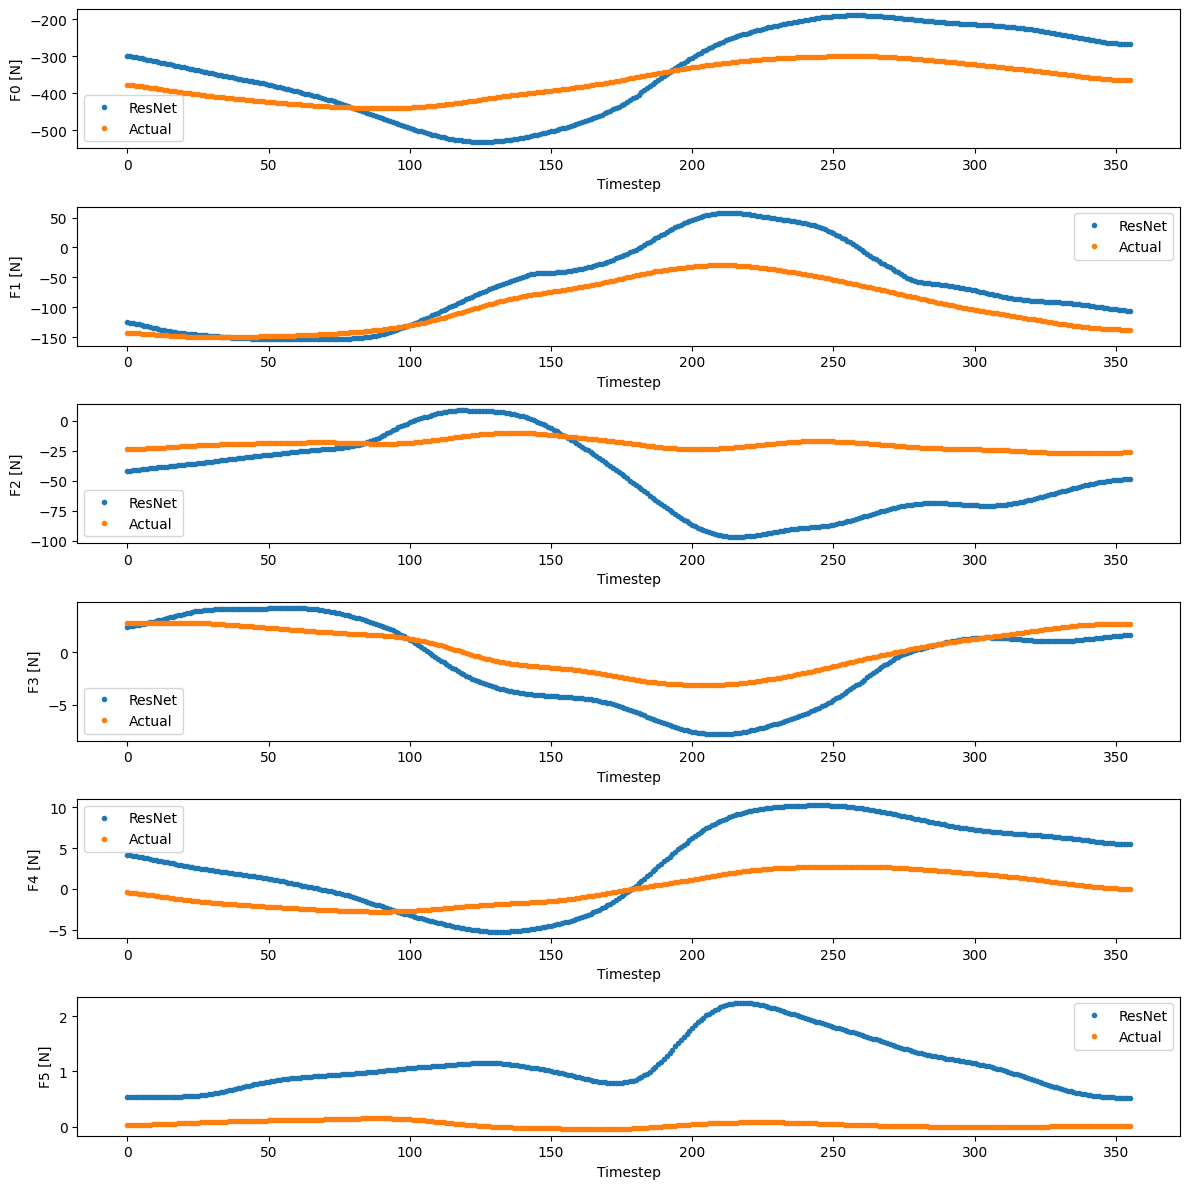

In [26]:
plt.figure(figsize=(12,12))

# Calculate the means of the predictions and testset_y along the first dimension
resnet_means = np.mean(resnet_predictions, axis=0)
testset_y_means = np.mean(testset_y, axis=0)
cycle = 0
# Iterate over each subplot
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(resnet_predictions[cycle, :, i], '.')  # Plot the means
    plt.plot(testset_y[cycle, :, i], '.')
    plt.xlabel('Timestep')
    plt.ylabel(f'F{i} [N]')
    plt.legend(['ResNet', 'Actual'])

plt.tight_layout()

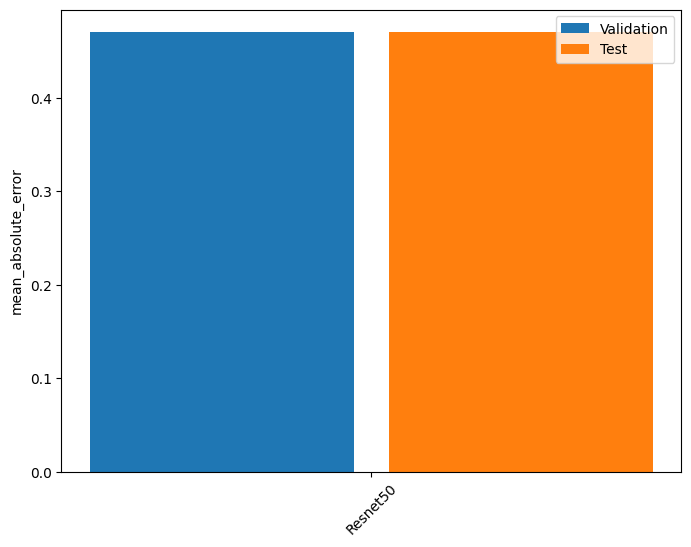

In [21]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = resnet_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=test_performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
import csv
with open('lstm_test_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, lstm_test_performance.keys())
    w.writeheader()
    w.writerows(lstm_test_performance)
    
with open('lstm_val_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, lstm_val_performance.keys())
    w.writeheader()
    w.writerow(lstm_val_performance)
    
with open('resnet_test_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, resnet_test_performance.keys())
    w.writeheader()
    w.writerow(resnet_test_performance)
    
with open('resnet_val_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, resnet_val_performance.keys())
    w.writeheader()
    w.writerow(resnet_val_performance)